### Regression Analysis

In [2]:
#importing and loading the data 
import pandas as pd 
df = pd.read_csv("C:/Users/bbuser/Downloads/CarPrice_Assignment.csv")
print(df.shape)
df.head()

(205, 26)


,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [5]:
df.isnull().sum()
df.dropna(inplace=True)

In [4]:
#encoding
cat_col = df.select_dtypes(include=["object"]).columns
print(cat_col)

Index(['CarName', 'fueltype', 'aspiration', 'doornumber', 'carbody',
       'drivewheel', 'enginelocation', 'enginetype', 'cylindernumber',
       'fuelsystem'],
      dtype='object')


In [6]:
#hot one encoding
df = pd.get_dummies(df, columns=cat_col, drop_first=True)

In [9]:
#traing and spitting data 
from sklearn.model_selection import train_test_split
x = df.drop("price", axis=1)
y = df["price"] 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

### EDA

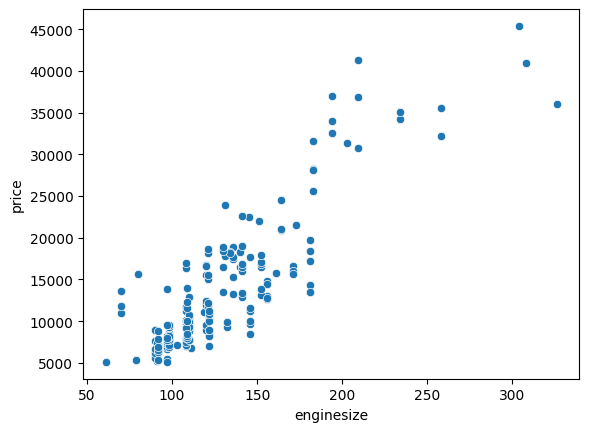

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(x="enginesize", y="price", data=df)
plt.show()


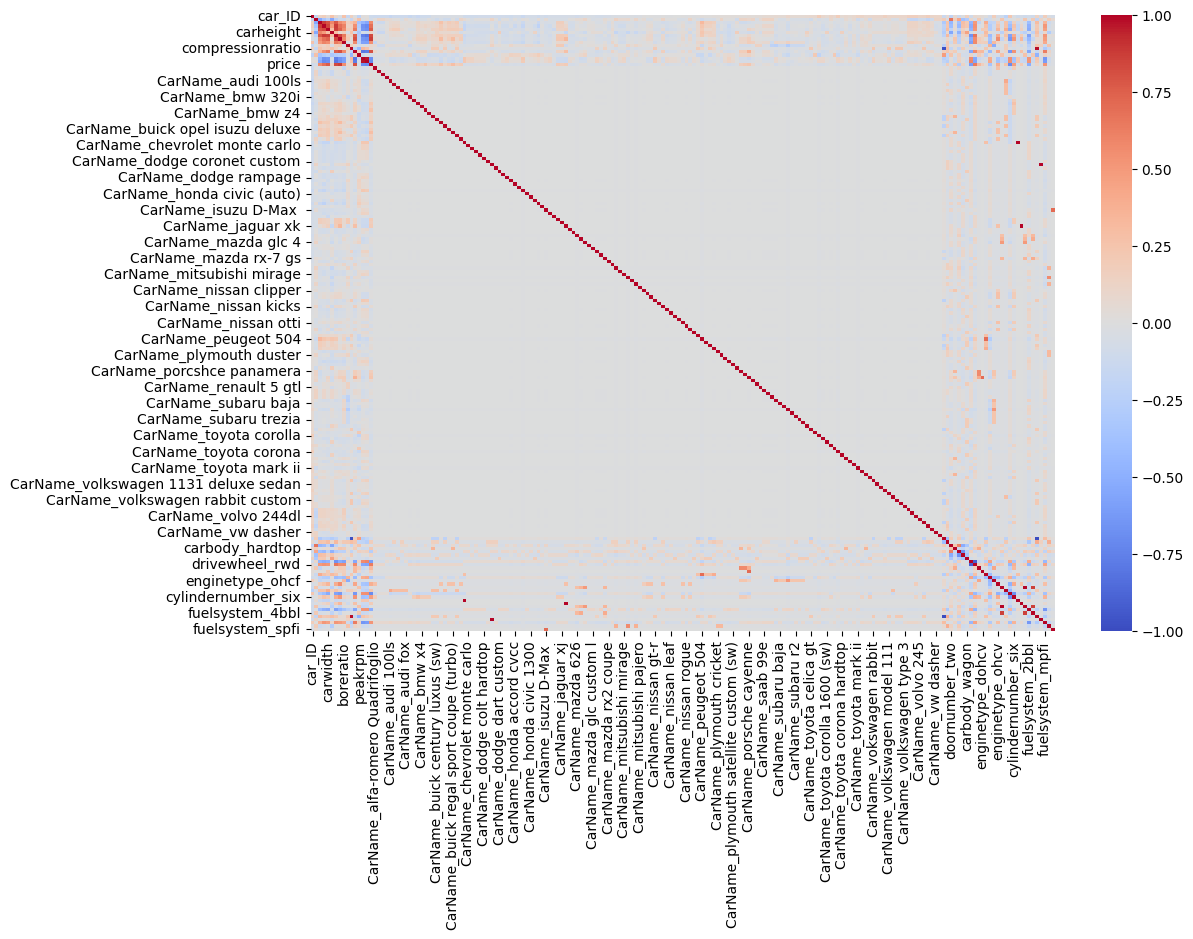

In [11]:
#HEAT MAP
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), cmap="coolwarm", annot=False)
plt.show()


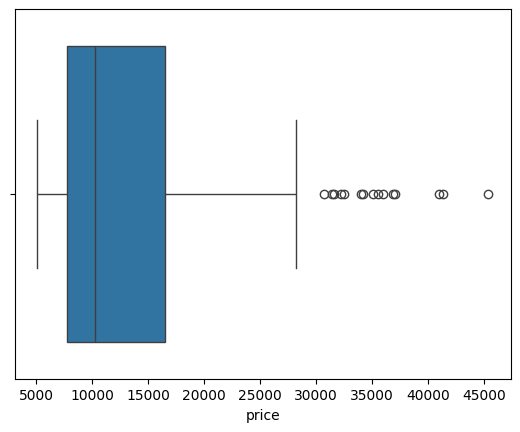

In [12]:
#BOXPLOT 
sns.boxplot(x=df["price"])
plt.show()


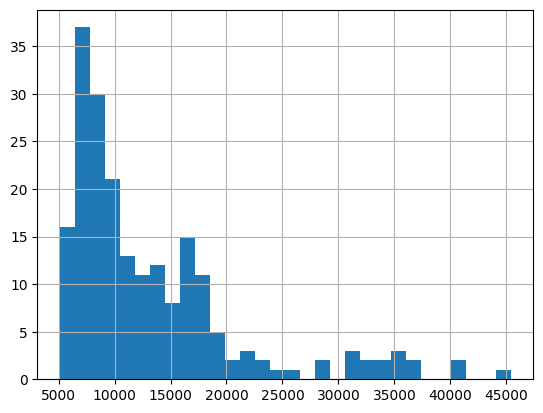

In [13]:
#DISTRUBUTION POLTS 
df["price"].hist(bins=30)
plt.show()


In [15]:
#Feature eng ideas 
#power to weight 
df["power_to_weight"] = df["horsepower"] / df["curbweight"]


### Model Development and Comparison

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Fit model on SCALED data
lr = LinearRegression()
lr.fit(x_train_scaled, y_train)  # Use scaled data
y_pred_lr = lr.predict(x_test_scaled)  # Use scaled data

print("Linear RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("Linear R2:", r2_score(y_test, y_pred_lr))



Linear RMSE: 13290.45950298863
Linear R2: -1.2374881825419721


In [34]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# STEP 1: Remove car_ID and other non-predictive features
print("=== STEP 1: FEATURE CLEANING ===")

# Remove car_ID (assuming it's the first column)
# You should also remove any other ID columns or non-predictive features
x_train_clean = x_train.drop('car_ID', axis=1) if 'car_ID' in x_train.columns else x_train.iloc[:, 1:]
x_test_clean = x_test.drop('car_ID', axis=1) if 'car_ID' in x_test.columns else x_test.iloc[:, 1:]

print(f"Features after removing car_ID: {x_train_clean.shape[1]}")

# STEP 2: Feature Selection - Reduce dimensionality
print("\n=== STEP 2: FEATURE SELECTION ===")

# Select top K features based on correlation with target
# Use fewer features than samples (rule of thumb: n_features < n_samples/5)
k_features = min(30, x_train_clean.shape[0] // 6)  # Conservative approach
print(f"Selecting top {k_features} features")

selector = SelectKBest(score_func=f_regression, k=k_features)
x_train_selected = selector.fit_transform(x_train_clean, y_train)
x_test_selected = selector.transform(x_test_clean)

print(f"Selected features shape: {x_train_selected.shape}")

# Get feature names if available
if hasattr(x_train_clean, 'columns'):
    selected_features = x_train_clean.columns[selector.get_support()]
    print("Selected features:", selected_features.tolist())

# STEP 3: Scale the selected features
print("\n=== STEP 3: FEATURE SCALING ===")
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_selected)
x_test_scaled = scaler.transform(x_test_selected)

# STEP 4: Try different models
print("\n=== STEP 4: MODEL COMPARISON ===")

models = {
    'Linear Regression': LinearRegression(),
    'Ridge (alpha=1)': Ridge(alpha=1.0),
    'Ridge (alpha=10)': Ridge(alpha=10.0),
    'Lasso (alpha=0.1)': Lasso(alpha=0.1),
    'Lasso (alpha=1)': Lasso(alpha=1.0)
}

results = {}

for name, model in models.items():
    # Fit model
    model.fit(x_train_scaled, y_train)
    y_pred = model.predict(x_test_scaled)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {'RMSE': rmse, 'R2': r2, 'predictions': y_pred}
    
    print(f"\n{name}:")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R²: {r2:.4f}")
    print(f"  Pred range: [{np.min(y_pred):.0f}, {np.max(y_pred):.0f}]")
    
    # Check for negative predictions
    neg_preds = np.sum(y_pred < 0)
    if neg_preds > 0:
        print(f"  {neg_preds} negative predictions!")

# STEP 5: Best model analysis
print("\n=== STEP 5: BEST MODEL ANALYSIS ===")
best_model_name = max(results.keys(), key=lambda k: results[k]['R2'])
best_r2 = results[best_model_name]['R2']
best_rmse = results[best_model_name]['RMSE']

print(f"Best model: {best_model_name}")
print(f"Best R²: {best_r2:.4f}")
print(f"Best RMSE: {best_rmse:.2f}")

=== STEP 1: FEATURE CLEANING ===
Features after removing car_ID: 189

=== STEP 2: FEATURE SELECTION ===
Selecting top 27 features
Selected features shape: (164, 27)
Selected features: ['wheelbase', 'carlength', 'carwidth', 'curbweight', 'enginesize', 'boreratio', 'horsepower', 'citympg', 'highwaympg', 'CarName_bmw x3', 'CarName_buick regal sport coupe (turbo)', 'CarName_jaguar xf', 'CarName_jaguar xk', 'CarName_porsche boxter', 'CarName_porsche cayenne', 'carbody_hardtop', 'carbody_hatchback', 'drivewheel_fwd', 'drivewheel_rwd', 'enginelocation_rear', 'enginetype_ohc', 'enginetype_ohcv', 'cylindernumber_four', 'cylindernumber_six', 'cylindernumber_twelve', 'fuelsystem_2bbl', 'fuelsystem_mpfi']

=== STEP 3: FEATURE SCALING ===

=== STEP 4: MODEL COMPARISON ===

Linear Regression:
  RMSE: 3917.64
  R²: 0.8056
  Pred range: [975, 35068]

Ridge (alpha=1):
  RMSE: 3883.49
  R²: 0.8090
  Pred range: [1297, 35006]

Ridge (alpha=10):
  RMSE: 3803.10
  R²: 0.8168
  Pred range: [2487, 33873]

La

Baseline RMSE: 8889.04
Improvement: 2.34x better than baseline


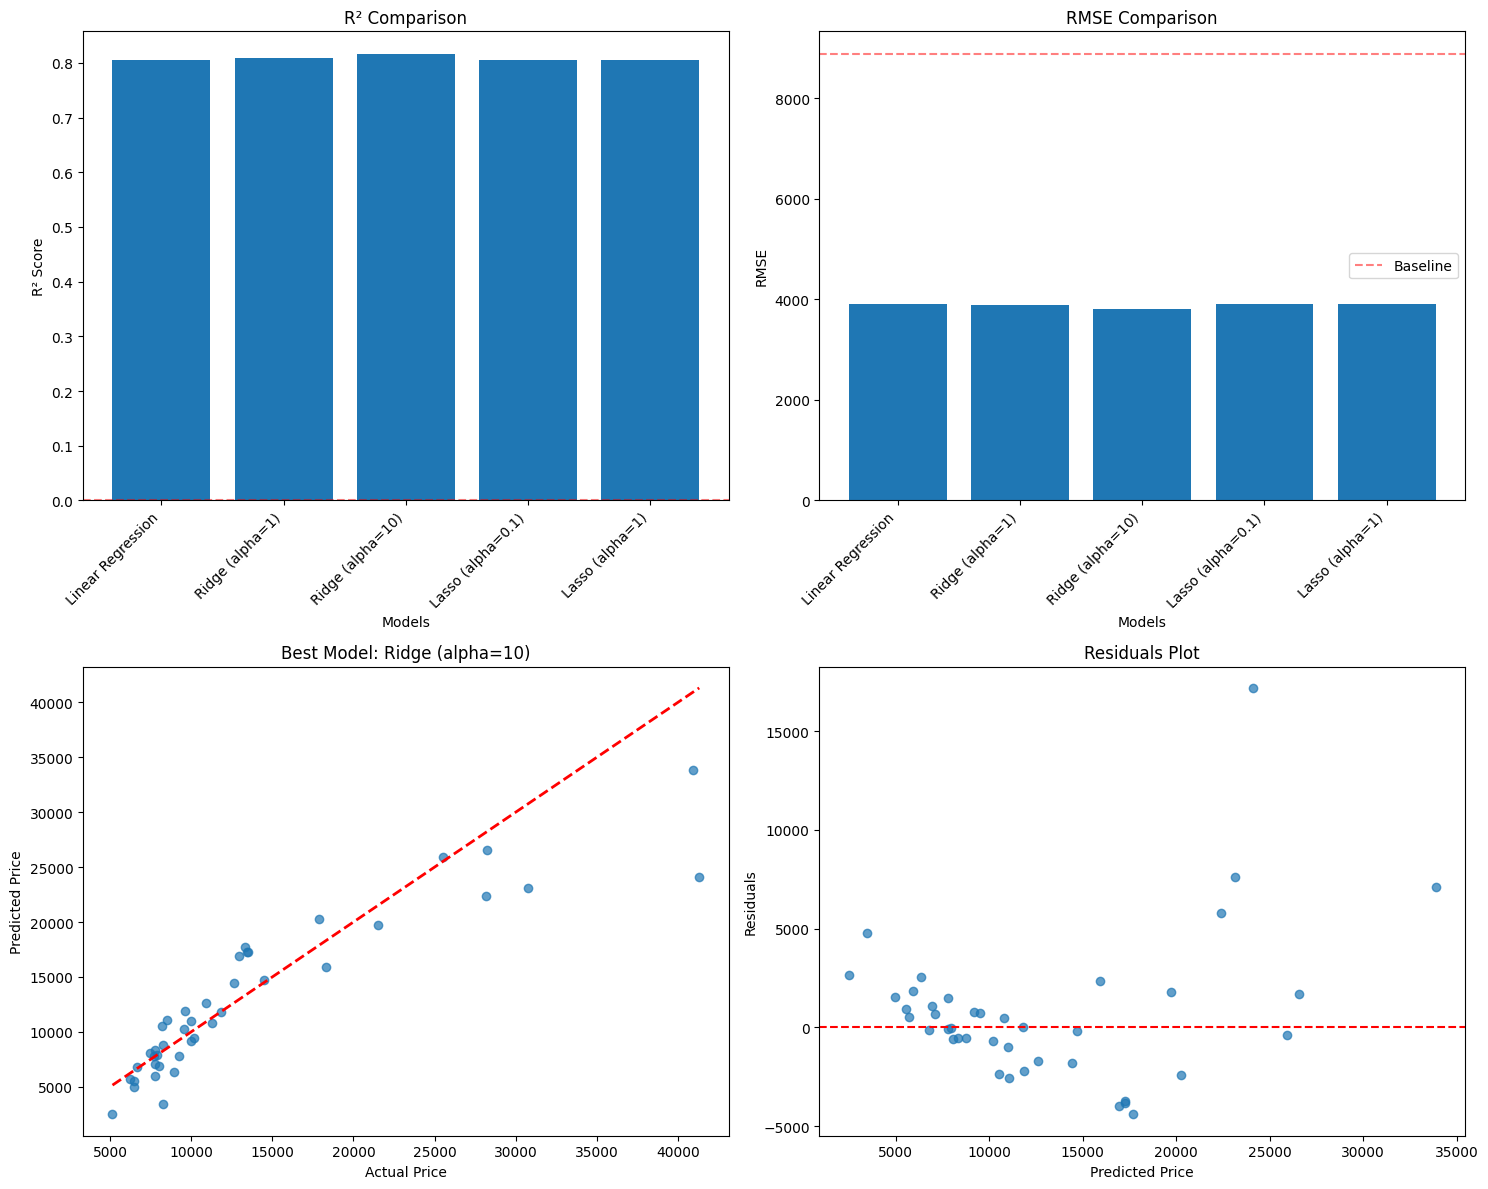


=== STEP 7: RECOMMENDATIONS ===
yayyyy

=== STEP 8: FEATURE IMPORTANCE ===
Top 10 most important features:
                                    feature   importance
19                      enginelocation_rear  2008.524437
4                                enginesize  1756.927840
2                                  carwidth  1404.246685
3                                curbweight  1394.479638
22                      cylindernumber_four  1394.060916
10  CarName_buick regal sport coupe (turbo)  1131.558423
6                                horsepower  1071.236522
23                       cylindernumber_six   967.228415
9                            CarName_bmw x3   741.835149
18                           drivewheel_rwd   739.506064


In [36]:
# Compare with baseline
baseline_rmse = np.sqrt(np.mean((y_test - np.mean(y_train))**2))
print(f"Baseline RMSE: {baseline_rmse:.2f}")
print(f"Improvement: {baseline_rmse/best_rmse:.2f}x better than baseline")

# STEP 6: Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Model comparison
model_names = list(results.keys())
r2_scores = [results[name]['R2'] for name in model_names]
rmse_scores = [results[name]['RMSE'] for name in model_names]

axes[0,0].bar(range(len(model_names)), r2_scores)
axes[0,0].set_xlabel('Models')
axes[0,0].set_ylabel('R² Score')
axes[0,0].set_title('R² Comparison')
axes[0,0].set_xticks(range(len(model_names)))
axes[0,0].set_xticklabels(model_names, rotation=45, ha='right')
axes[0,0].axhline(y=0, color='r', linestyle='--', alpha=0.5)

# Plot 2: RMSE comparison
axes[0,1].bar(range(len(model_names)), rmse_scores)
axes[0,1].set_xlabel('Models')
axes[0,1].set_ylabel('RMSE')
axes[0,1].set_title('RMSE Comparison')
axes[0,1].set_xticks(range(len(model_names)))
axes[0,1].set_xticklabels(model_names, rotation=45, ha='right')
axes[0,1].axhline(y=baseline_rmse, color='r', linestyle='--', alpha=0.5, label='Baseline')
axes[0,1].legend()

# Plot 3: Best model - Actual vs Predicted
best_preds = results[best_model_name]['predictions']
axes[1,0].scatter(y_test, best_preds, alpha=0.7)
axes[1,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1,0].set_xlabel('Actual Price')
axes[1,0].set_ylabel('Predicted Price')
axes[1,0].set_title(f'Best Model: {best_model_name}')

# Plot 4: Residuals
residuals = y_test - best_preds
axes[1,1].scatter(best_preds, residuals, alpha=0.7)
axes[1,1].axhline(y=0, color='r', linestyle='--')
axes[1,1].set_xlabel('Predicted Price')
axes[1,1].set_ylabel('Residuals')
axes[1,1].set_title('Residuals Plot')

plt.tight_layout()
plt.show()

# STEP 7: Recommendations
print("\n=== STEP 7: RECOMMENDATIONS ===")
if best_r2 > 0.5:
    print("yayyyy")

# STEP 8: Feature importance (for Ridge/Lasso)
if 'Ridge' in best_model_name or 'Lasso' in best_model_name:
    print("\n=== STEP 8: FEATURE IMPORTANCE ===")
    best_model = models[best_model_name]
    coef_importance = np.abs(best_model.coef_)
    
    if hasattr(x_train_clean, 'columns'):
        feature_importance = pd.DataFrame({
            'feature': selected_features,
            'importance': coef_importance
        }).sort_values('importance', ascending=False)
        
        print("Top 10 most important features:")
        print(feature_importance.head(10))